In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [2]:
top_review = pd.read_pickle('top_review.pickle')

In [3]:
business = pd.read_csv('business.csv', index_col=0)

In [4]:
names = business.iloc[:,[0,1]]

In [5]:
top_review = pd.merge(left=top_review,right=names, on='business_id',how='left')

In [6]:
top_review.head(3)

,text,Italian Cuisine,Asian Cuisine,Pizza,Experience,Seafood,Bars,Service,Sandwich/Breakfast,Burgers,business_id,review_id,review_star,character_count,word_count,sentiment,name
0,great service we went in around pm on a wee...,0.00000,0.00000,0.0,0.03106,0.00000,0.00000,0.00000,0.0,0.20605,Hc9l2eLAGTB4lZJI3vRoPw,Lr1km0fiXuyW9pBn1-4u-Q,4,756,149,positive,Tasty Burger
1,came here with a friend on a saturday night ar...,0.01450,0.02012,0.0,0.02418,0.00038,0.01834,0.01449,0.0,0.06780,_RWkck7niE8VJG3zLXK2ig,nJALqXh3fGJAfNobbQ6F_w,4,1075,197,positive,Silvertone
2,went there last night with my husband the ser...,0.01178,0.03270,0.0,0.00545,0.01159,0.01017,0.01728,0.0,0.00000,CHcwpvcUr1G7bAF0k0JnMQ,8mTx-7ullerN9jwV_8cupg,4,1192,215,positive,Van Shabu & Bar


In [7]:
top_review_cp = top_review.iloc[:,:10].copy()

In [8]:
top_review_cp.head()

,text,Italian Cuisine,Asian Cuisine,Pizza,Experience,Seafood,Bars,Service,Sandwich/Breakfast,Burgers
0,great service we went in around pm on a wee...,0.00000,0.00000,0.00000,0.03106,0.00000,0.00000,0.00000,0.00000,0.20605
1,came here with a friend on a saturday night ar...,0.01450,0.02012,0.00000,0.02418,0.00038,0.01834,0.01449,0.00000,0.06780
2,went there last night with my husband the ser...,0.01178,0.03270,0.00000,0.00545,0.01159,0.01017,0.01728,0.00000,0.00000
3,this place is such a cute little gem of a hole...,0.01583,0.00923,0.00119,0.03002,0.00110,0.00263,0.00696,0.04273,0.00266
4,will miss this place sincerely it was the bes...,0.01175,0.00000,0.00086,0.12838,0.00000,0.00000,0.00000,0.00000,0.00000


In [9]:
top_review_cp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 0 to 59999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   text                60000 non-null  object 
 1   Italian Cuisine     60000 non-null  float64
 2   Asian Cuisine       60000 non-null  float64
 3   Pizza               60000 non-null  float64
 4   Experience          60000 non-null  float64
 5   Seafood             60000 non-null  float64
 6   Bars                60000 non-null  float64
 7   Service             60000 non-null  float64
 8   Sandwich/Breakfast  60000 non-null  float64
 9   Burgers             60000 non-null  float64
dtypes: float64(9), object(1)
memory usage: 5.0+ MB


In [10]:
# find the max topic by row (review)
top_review_cp['main_topic'] = top_review_cp.iloc[:,1:].idxmax(axis=1)

In [11]:
top_review_cp.head()

,text,Italian Cuisine,Asian Cuisine,Pizza,Experience,Seafood,Bars,Service,Sandwich/Breakfast,Burgers,main_topic
0,great service we went in around pm on a wee...,0.00000,0.00000,0.00000,0.03106,0.00000,0.00000,0.00000,0.00000,0.20605,Burgers
1,came here with a friend on a saturday night ar...,0.01450,0.02012,0.00000,0.02418,0.00038,0.01834,0.01449,0.00000,0.06780,Burgers
2,went there last night with my husband the ser...,0.01178,0.03270,0.00000,0.00545,0.01159,0.01017,0.01728,0.00000,0.00000,Asian Cuisine
3,this place is such a cute little gem of a hole...,0.01583,0.00923,0.00119,0.03002,0.00110,0.00263,0.00696,0.04273,0.00266,Sandwich/Breakfast
4,will miss this place sincerely it was the bes...,0.01175,0.00000,0.00086,0.12838,0.00000,0.00000,0.00000,0.00000,0.00000,Experience


In [12]:
top_review_cp = top_review_cp[['text','main_topic']]

In [13]:
# One hot encoding
temp_df = pd.get_dummies(top_review_cp['main_topic'])

# merge into original df
reviews_topic_importance = pd.merge(left=top_review_cp,
                                    right=temp_df,
                                    left_index=True,
                                    right_index=True)

In [14]:
reviews_topic_importance.head()


,text,main_topic,Asian Cuisine,Bars,Burgers,Experience,Italian Cuisine,Pizza,Sandwich/Breakfast,Seafood,Service
0,great service we went in around pm on a wee...,Burgers,0,0,1,0,0,0,0,0,0
1,came here with a friend on a saturday night ar...,Burgers,0,0,1,0,0,0,0,0,0
2,went there last night with my husband the ser...,Asian Cuisine,1,0,0,0,0,0,0,0,0
3,this place is such a cute little gem of a hole...,Sandwich/Breakfast,0,0,0,0,0,0,1,0,0
4,will miss this place sincerely it was the bes...,Experience,0,0,0,1,0,0,0,0,0


In [15]:
reviews_topic_importance.drop(['text','main_topic'],axis=1,inplace=True)
reviews_topic_importance.head()

,Asian Cuisine,Bars,Burgers,Experience,Italian Cuisine,Pizza,Sandwich/Breakfast,Seafood,Service
0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0


In [16]:
count_positives = pd.DataFrame(reviews_topic_importance.sum(axis=0),columns=['count_positive_sentiment'])
count_positives.sort_values(['count_positive_sentiment'],ascending=False)

,count_positive_sentiment
Service,11847
Italian Cuisine,9475
Asian Cuisine,8889
Experience,7427
Bars,6855
Sandwich/Breakfast,6684
Seafood,3294
Pizza,2801
Burgers,2728


# Baseline Modeling

##### Logistic Regression

In [17]:
features = top_review.iloc[:,1:10]

In [18]:
target = top_review['sentiment']

In [19]:
# run logistic regression as baseline

# define scaler
scaler = StandardScaler()

# split data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=42)

# scale data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# logistic regression -- define and fit model on training data
lr_baseline = LogisticRegression(C=1) # need to rebalance positive and negative sentiment classes
lr_baseline.fit(X_train_scaled, y_train)

# logistic regression -- compute prediction on testing data
lr_y_pred = lr_baseline.predict(X_test_scaled)

# logistic regression -- score model based on standard accuracy metric and f1 beta score (metric to optimize for in my model) 
lr_accuracy_baseline = lr_baseline.score(X_test_scaled, y_test)
lr_fscore_baseline = f1_score(y_test, lr_y_pred, pos_label = 'positive') # indicate positive class as positive

print('Logistic Regression Test Accuracy score:', '{0:.4g}'.format(lr_accuracy_baseline))
print('Logistic Regression Test F1 score:', '{0:.4g}'.format(lr_fscore_baseline))

Logistic Regression Test Accuracy score: 0.7433
Logistic Regression Test F1 score: 0.7447


In [20]:
# print coefficients
log_odds = lr_baseline.coef_[0]
pd.DataFrame(log_odds, 
             features.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
Experience,1.084006
Italian Cuisine,0.379220
Sandwich/Breakfast,0.285469
Seafood,0.253433
Asian Cuisine,0.084845
Pizza,0.078133
Bars,0.045448
Burgers,-0.007831
Service,-1.118279


##### Random Forest

In [21]:
top_review.replace({'sentiment' : { 'positive' : 1, 'negative' : 0}},inplace=True)

In [22]:
%%time
# define X and Y
X = top_review.iloc[:,1:10]
y = top_review['sentiment']

# hold out 20% of the data for final testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42,stratify=y)  


# initiate RF classifier and fit the model on training data
rf = RandomForestClassifier(n_estimators=200, criterion = 'gini', bootstrap=True, n_jobs = -1, random_state=42) 
rf.fit(X_train, y_train)

# prediction on test data
y_pred = rf.predict(X_test)

# score model on test set (final model score)
rf_f1 = f1_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred) 
rf_recall = recall_score(y_test, y_pred)
rf_accuracy = accuracy_score(y_test, y_pred) 

# print results
print(f'Random Forest | Test F1 score: \t{rf_f1}\n')
print(f'Random Forest | Test Precision: {rf_precision}\n')
print(f'Random Forest | Test Recall: \t{rf_recall}\n')
print(f'Random Forest | Test Accuracy: \t{rf_accuracy}\n')

Random Forest | Test F1 score: 	0.7711927981995499

Random Forest | Test Precision: 0.7713856928464232

Random Forest | Test Recall: 	0.771

Random Forest | Test Accuracy: 	0.77125

CPU times: user 38 s, sys: 541 ms, total: 38.5 s
Wall time: 12 s


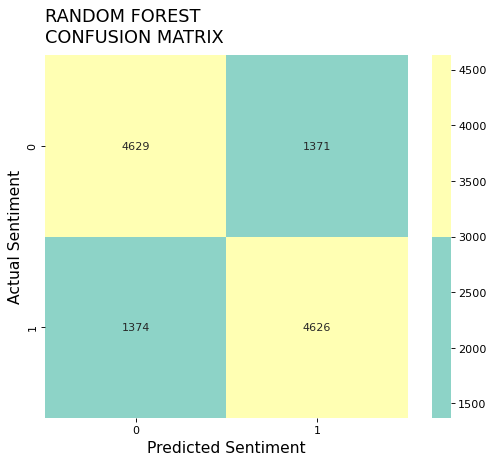

In [23]:
# Confusion Matrix

rf_confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6), dpi=80)
color = sns.color_palette('Set3',n_colors=2)
sns.heatmap(rf_confusion, cmap = color, annot=True, square=True, fmt=".0f")

plt.xlabel('Predicted Sentiment',fontsize = 14)
plt.ylabel('Actual Sentiment',fontsize = 14)
plt.title('RANDOM FOREST\nCONFUSION MATRIX', fontsize = 16, loc = 'left', pad = 12);
plt.savefig('confusion.png');

In [25]:
rf_feature_importance = pd.DataFrame(np.round(rf.feature_importances_,4), index=features.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)
rf_feature_importance

,feature importance
Service,0.2489
Experience,0.2165
Italian Cuisine,0.1040
Asian Cuisine,0.0860
Sandwich/Breakfast,0.0833
Seafood,0.0755
Bars,0.0711
Pizza,0.0583
Burgers,0.0563


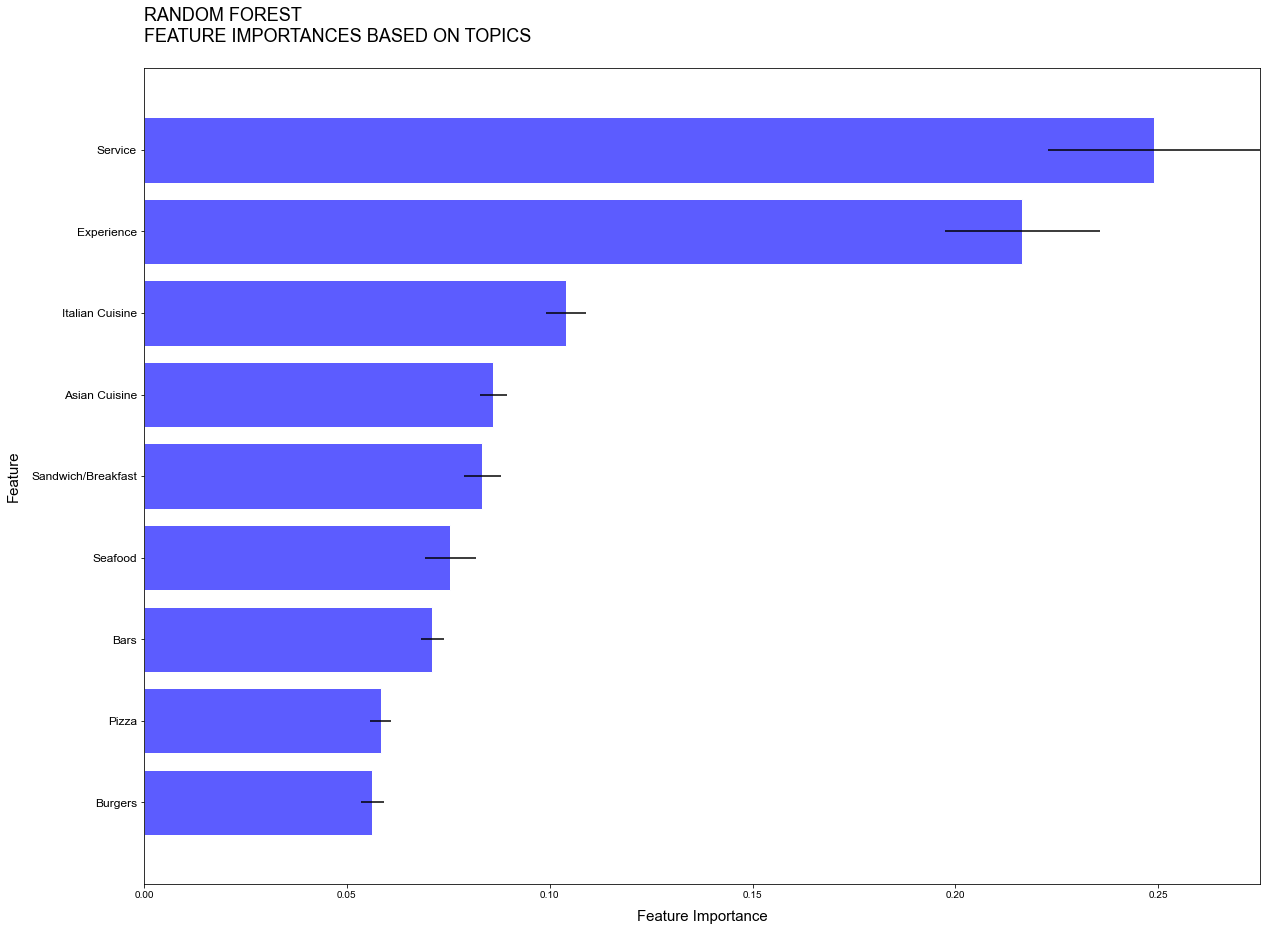

In [28]:
# Random Forest Validation | Plot feature importances

# compute feature importance and std
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)

# plot the feature importances of the random forest
plt.figure(figsize=(20,15))
plt.margins(x=0)
sns.set_style("whitegrid")
plt.title("RANDOM FOREST\nFEATURE IMPORTANCES BASED ON TOPICS\n",fontsize = 18,loc = 'left')
ax = plt.barh(range(X_test.shape[1]), importances[indices],
       color = '#5c5cff', xerr=std[indices], align="center")

# set labels
plt.xlabel('Feature Importance',labelpad = 10,fontsize = 15)
plt.ylabel('Feature',labelpad = 10,fontsize = 15)
plt.yticks(range(X_test.shape[1]), [features.columns[i] for i in indices],fontsize = 12)
plt.ylim([-1, X_test.shape[1]])
plt.savefig('importances.png')
plt.show();
